This notebook is for creating the base ML model.

In [32]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('train_2021-22-23-24.csv')
df.drop('Zone', axis=1, inplace=True)

print(df.columns)

Index(['#', 'datetime', 'location', 'busyness'], dtype='object')


In [24]:
df.shape

(7319643, 4)

In [22]:
df.loc[df['busyness']>2]

,#,datetime,location,busyness
120580,120581,2021-01-20 15:00:00,236,3
126706,126707,2021-01-21 15:00:00,236,3
169403,169404,2021-01-28 14:00:00,236,3
169662,169663,2021-01-28 15:00:00,236,3
175806,175807,2021-01-29 15:00:00,236,3
...,...,...,...,...
7318730,7318731,2024-03-31 20:00:00,132,3
7318736,7318737,2024-03-31 20:00:00,138,3
7318989,7318990,2024-03-31 21:00:00,132,3
7318995,7318996,2024-03-31 21:00:00,138,3


In [3]:
df.head()

,#,datetime,location,busyness,Zone
0,1,2021-01-01 00:00:00,3,1,Allerton/Pelham Gardens
1,2,2021-01-01 00:00:00,4,1,Alphabet City
2,3,2021-01-01 00:00:00,5,1,Arden Heights
3,4,2021-01-01 00:00:00,6,1,Arrochar/Fort Wadsworth
4,5,2021-01-01 00:00:00,7,1,Astoria


In [4]:
# Drop the 'zone' column
df = df.drop(columns=['Zone'])

print(df.dtypes)

#            int64
datetime    object
location     int64
busyness     int64
dtype: object


In [6]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    #  busyness
item_id timestamp              
3       2021-01-01  1         1
4       2021-01-01  2         1
5       2021-01-01  3         1
6       2021-01-01  4         1
7       2021-01-01  5         1


In [7]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [9]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path="base_model"
)
print('we made the predictor')

we made the predictor


In [11]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'base_model'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       6.64 GB / 15.90 GB (41.8%)
Disk Space Avail:   2148.96 GB / 2794.50 GB (76.9%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0%), 261 time series. M

In [69]:
predictor = TimeSeriesPredictor.load(path='autogluon-m4-hourly')

This means that the predictor was fit in a version `<=0.7.0`.

############################## WARNING ##############################
	Predictor Version: Unknown (Likely <=0.7.0)
	Current Version:   1.1.0
############################## WARNING ##############################



AssertionError: Predictor was created on version Unknown (Likely <=0.7.0) but is being loaded with version 1.1.0. Please ensure the versions match to avoid instability. While it is NOT recommended, this error can be bypassed by specifying `require_version_match=False`.

In [12]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -2.354214       1.216456          90.897378          7
1     SeasonalNaive  -2.354214       1.216456           4.613916          2
2             Naive  -3.107709       4.146060           5.000787          1
3               ETS  -8.481636     116.471347           4.958518          5
4             Theta -10.349563      34.489694           4.842501          6
5     DirectTabular -21.902781       6.038521          15.189929          4
6  RecursiveTabular -38.654576     307.437855          76.746438          3


In [70]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


                             mean  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
item_id timestamp                                                             
3       2024-01-01 23:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2024-01-02 00:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2024-01-02 01:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2024-01-02 02:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2024-01-02 03:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
...                           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
110     2022-04-23 13:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2022-04-23 14:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2022-04-23 15:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2022-04-23 16:00:00   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
        2022-04-23 17:00:00   1.0  1.0  1.0  1.0  1.

In [58]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.


In [73]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
for i in range(4):
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=1)
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])

data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


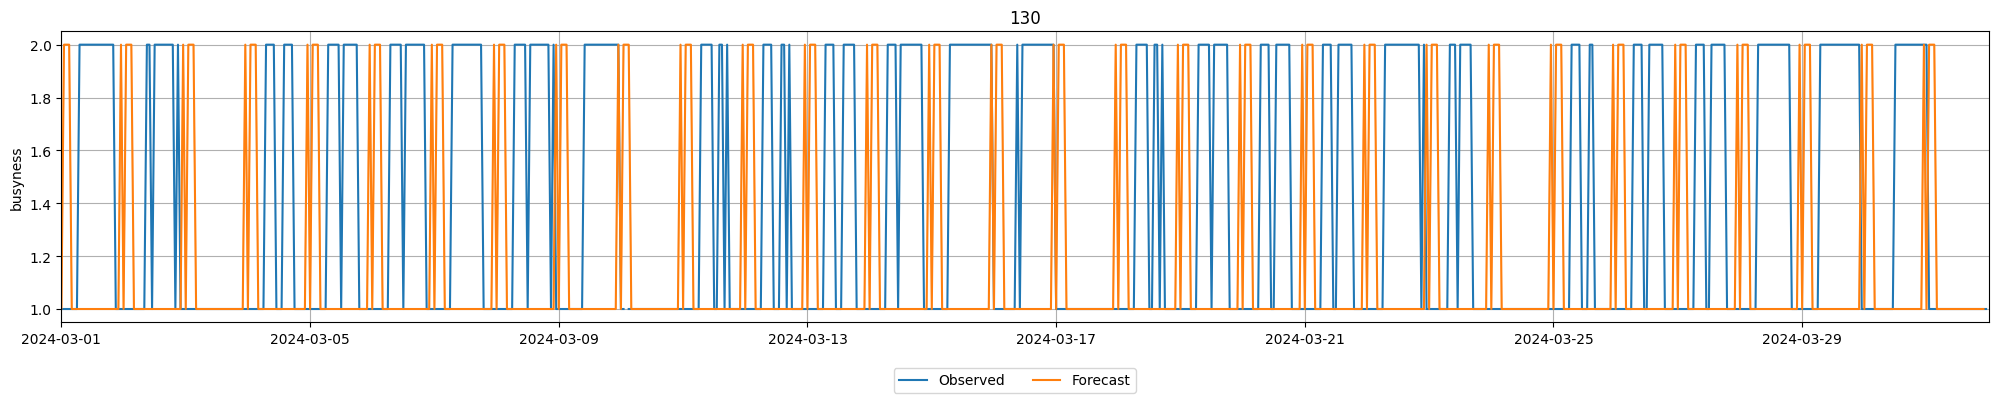

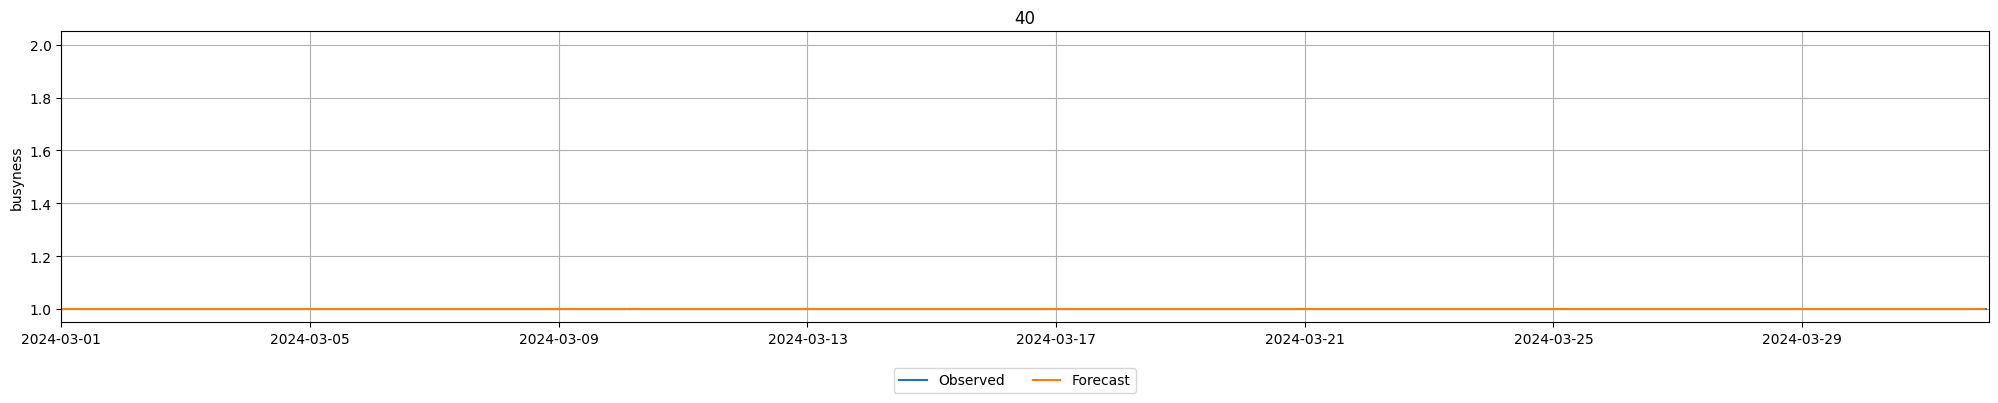

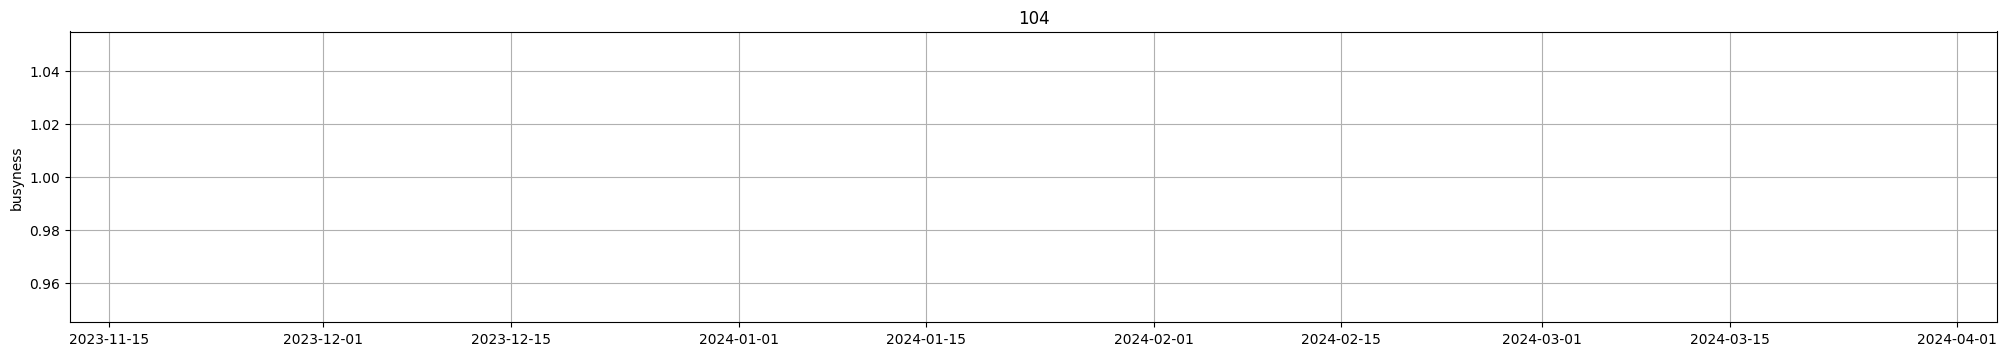

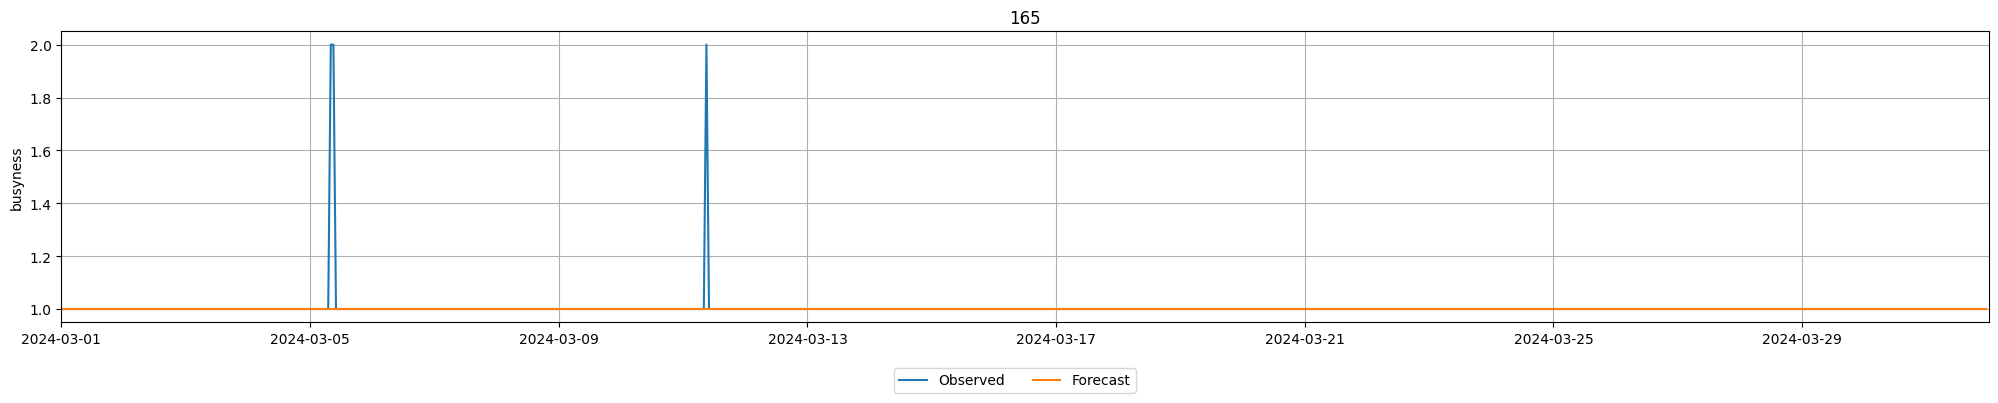

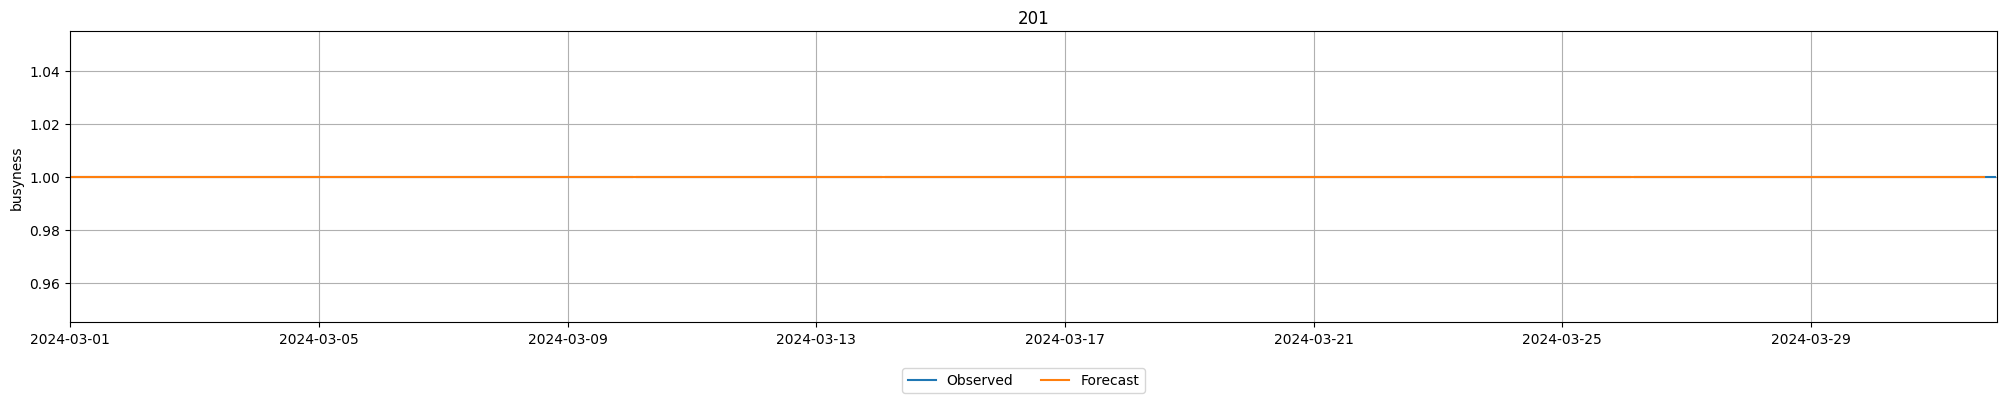

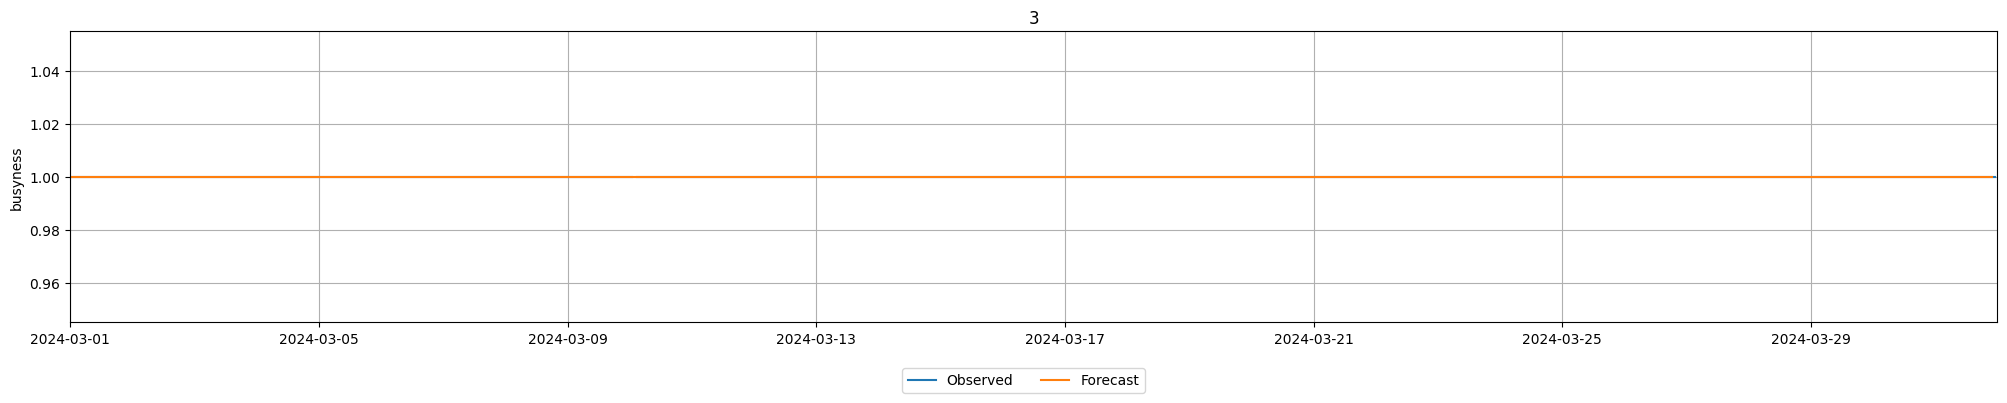

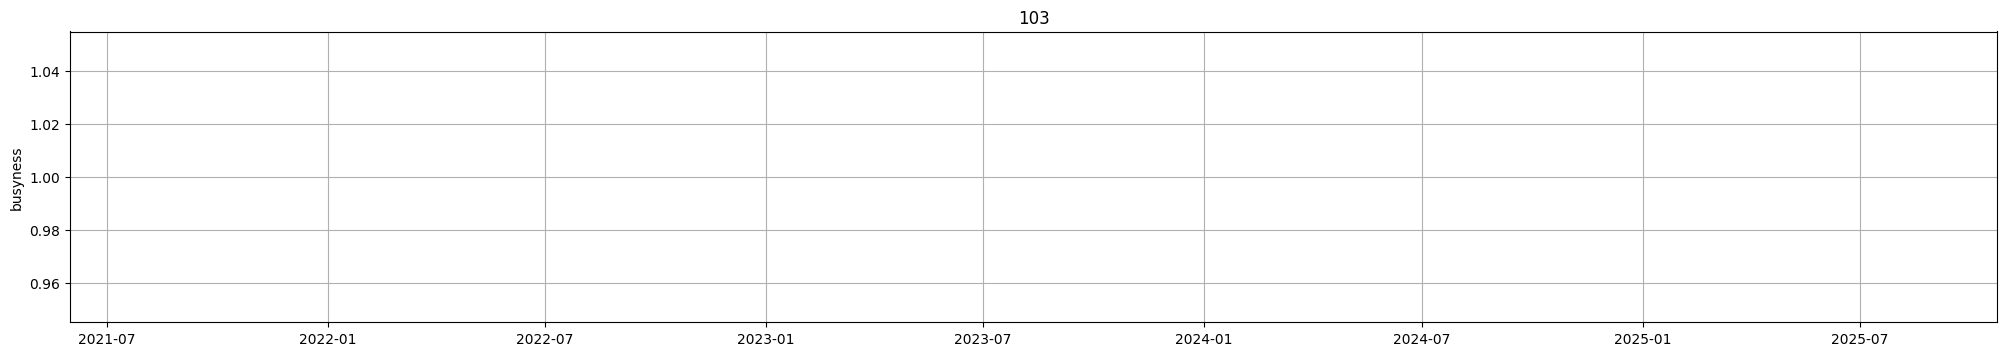

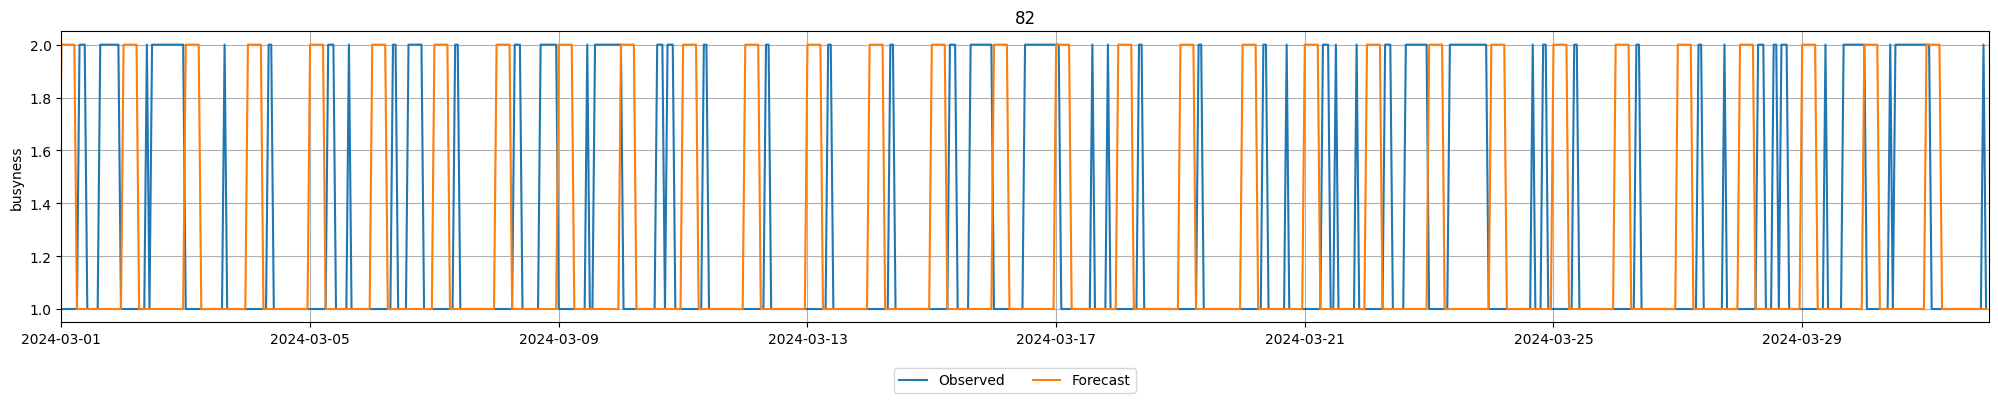

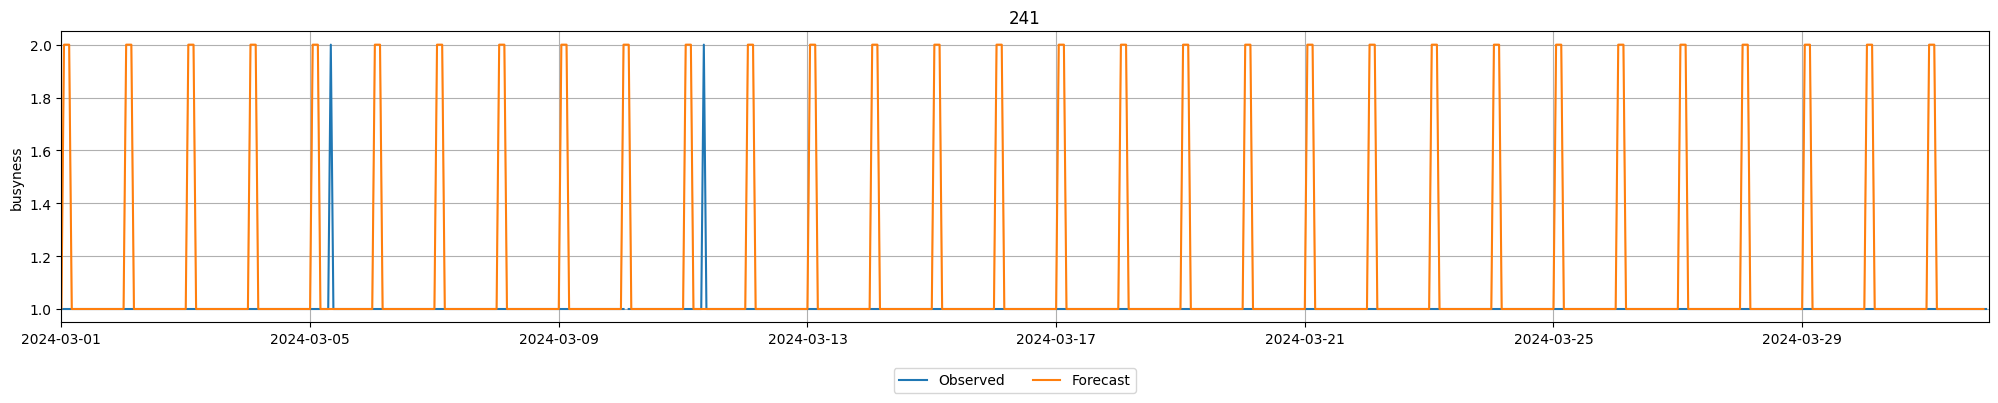

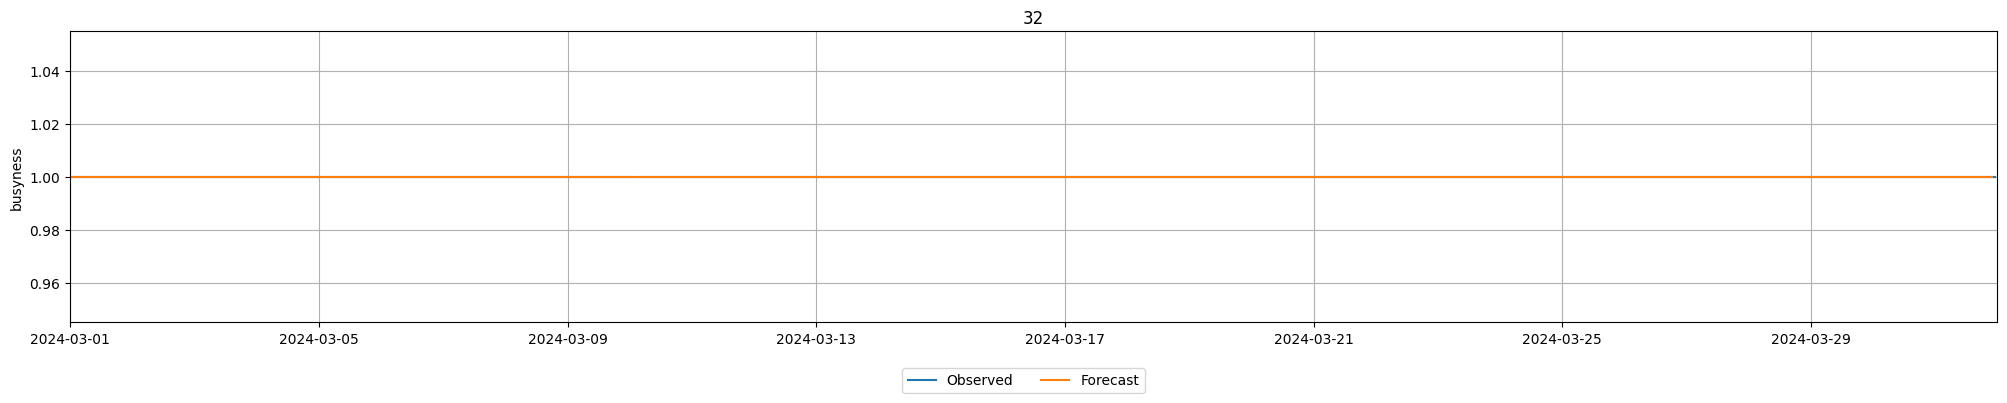

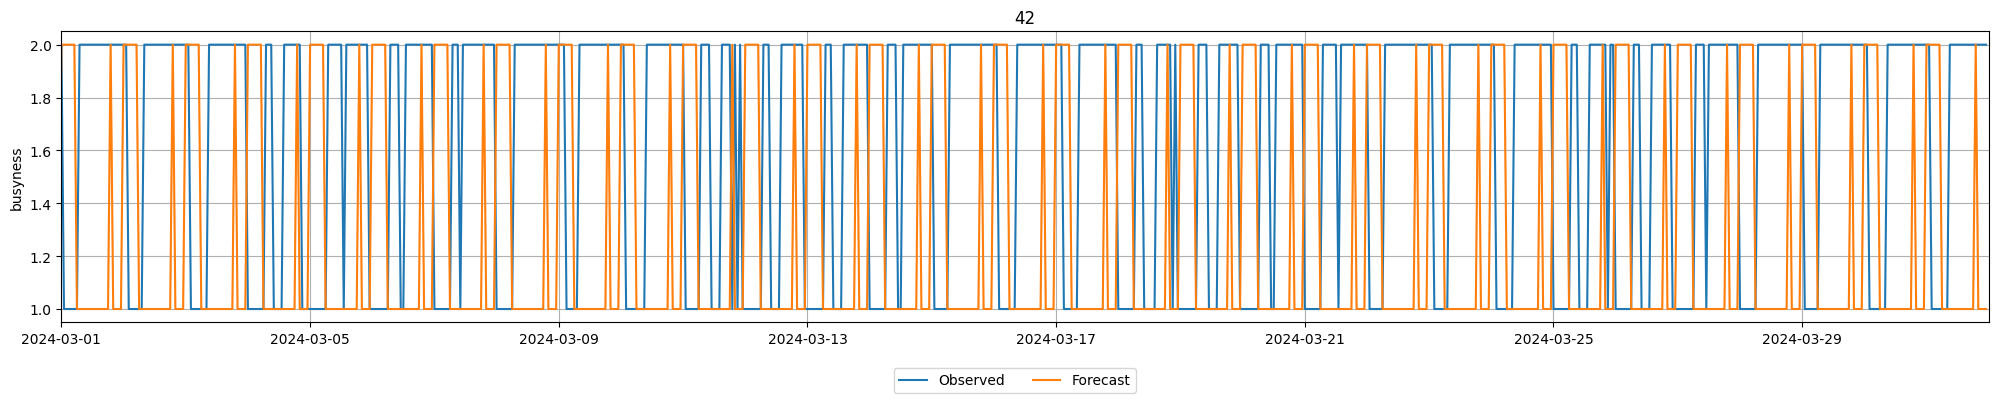

In [74]:
plt.show()